In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import logging
from pathlib import Path

import arviz as az
import numpyro

from hb_mep.config import HBMepConfig
from hb_mep.data_access import DataClass
# from hb_mep.models.human import MixtureModel
from hb_mep.models.human.utils import load_data
from hb_mep.utils import plot

numpyro.set_platform("cpu")
numpyro.set_host_device_count(12)
numpyro.enable_x64()


import logging

import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd

import numpyro
import numpyro.distributions as dist
from numpyro.distributions.mixtures import MixtureGeneral
from numpyro.infer import MCMC, NUTS
from numpyro.diagnostics import hpdi

from hb_mep.config import HBMepConfig
from hb_mep.models.baseline import Baseline
from hb_mep.models.utils import Site as site
from hb_mep.utils import timing
from hb_mep.utils.constants import (
    INTENSITY,
    RESPONSE,
    PARTICIPANT,
    FEATURES
)


logger = logging.getLogger(__name__)

PARENT_PATH = Path(os.getcwd()).parent.parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

In [3]:
class MixtureModel(Baseline):
    def __init__(self, config: HBMepConfig):
        super(MixtureModel, self).__init__(config=config)
        self.name = "Mixture_Model"

        self.columns = [PARTICIPANT, FEATURES[1]]
        self.x = np.linspace(0, 15, 100)
        self.xpad = 2

    def _model(self, intensity, participant, feature1, response_obs=None):
        n_participant = np.unique(participant).shape[0]
        n_feature1 = np.unique(feature1).shape[0]

        with numpyro.plate("n_participant", n_participant, dim=-1):
            """ Hyper-priors """
            a_mean = numpyro.sample(
                site.a_mean,
                dist.TruncatedDistribution(dist.Normal(5, 10), low=0)
            )
            a_scale = numpyro.sample(site.a_scale, dist.HalfNormal(200))

            b_scale = numpyro.sample(site.b_scale, dist.HalfNormal(200))

            h_scale = numpyro.sample("h_scale", dist.HalfNormal(200))
            v_scale = numpyro.sample("v_scale", dist.HalfNormal(200))

            lo_scale = numpyro.sample(site.lo_scale, dist.HalfNormal(0.2))

            with numpyro.plate("n_feature1", n_feature1, dim=-2):
                """ Priors """
                a = numpyro.sample(
                    site.a,
                    dist.TruncatedDistribution(dist.Normal(a_mean, a_scale), low=0)
                )
                b = numpyro.sample(site.b, dist.HalfNormal(b_scale))

                h = numpyro.sample("h", dist.HalfNormal(h_scale))
                v = numpyro.sample("v", dist.HalfNormal(v_scale))

                lo = numpyro.sample(site.lo, dist.HalfNormal(lo_scale))

                d = numpyro.sample("d", dist.Gamma(2, 0.1))

                noise_offset = numpyro.sample(
                    site.noise_offset,
                    dist.HalfCauchy(.2)
                )
                noise_slope = numpyro.sample(
                    site.noise_slope,
                    dist.HalfCauchy(.2)
                )

        """ Model """
        mean = numpyro.deterministic(
            site.mean,
            lo[feature1, participant] + \
            jnp.maximum(
                0,
                -1 + \
                (h[feature1, participant] + 1) / \
                jnp.power(
                    1 + \
                    (jnp.power(1 + h[feature1, participant], v[feature1, participant]) - 1) * \
                    jnp.exp(-b[feature1, participant] * (intensity - a[feature1, participant])),
                    1 / v[feature1, participant]
                )
            )
        )

        sigma = numpyro.deterministic(
            "sigma",
            noise_offset[feature1, participant] + \
            noise_slope[feature1, participant] * \
            mean
        )

        df = numpyro.deterministic("df", d[feature1, participant])

        """ Observation """
        with numpyro.plate("data", len(intensity)):
            return numpyro.sample(site.obs, dist.StudentT(df, mean, sigma), obs=response_obs)

    @timing
    def run_inference(self, df: pd.DataFrame) -> tuple[numpyro.infer.mcmc.MCMC, dict]:
        """
        Run MCMC inference
        """
        response = df[RESPONSE].to_numpy().reshape(-1,)
        participant = df[PARTICIPANT].to_numpy().reshape(-1,)
        feature1 = df[FEATURES[1]].to_numpy().reshape(-1,)
        intensity = df[INTENSITY].to_numpy().reshape(-1,)

        # MCMC
        nuts_kernel = NUTS(self._model)
        mcmc = MCMC(nuts_kernel, **self.config.MCMC_PARAMS)
        rng_key = jax.random.PRNGKey(self.random_state)
        logger.info(f"Running inference with {self.name} ...")
        mcmc.run(rng_key, intensity, participant, feature1, response)
        posterior_samples = mcmc.get_samples()

        return mcmc, posterior_samples

    def _get_estimates(
        self,
        posterior_samples: dict,
        posterior_means: dict,
        c: tuple
    ):
        a = posterior_means[site.a][c[::-1]]
        b = posterior_means[site.b][c[::-1]]
        h = posterior_means["h"][c[::-1]]
        v = posterior_means["v"][c[::-1]]
        lo = posterior_means[site.lo][c[::-1]]

        y = lo + jnp.maximum(
            0,
            -1 + (h + 1) / \
            jnp.power(1 + (jnp.power(1 + h, v) - 1) * jnp.exp(-b * (self.x - a)), 1 / v)
        )

        threshold_samples = posterior_samples[site.a][:, c[1], c[0]]
        hpdi_interval = hpdi(threshold_samples, prob=0.95)

        return y, a, threshold_samples, hpdi_interval

#### Load config

In [4]:
config = HBMepConfig()
config.CURRENT_PATH = PARENT_PATH


#### Load data and preprocess

In [5]:
data = DataClass(config)

# df = load_data(data=data, muscle="Triceps")
subset = ["scapptio001", "cornptio013"]
# subset = ["cornptio012", "cornptio017"]
# subset = ["scapptio001", "cornptio017", "cornptio015", "cornptio013"]
df = load_data(data=data, muscle="Triceps", subset=subset)

df, encoder_dict = data.build(df)


2023-06-04 09:22:19,221 - hb_mep.utils.utils - INFO - func:load_data took: 0.15 sec
2023-06-04 09:22:19,222 - hb_mep.data_access.core - INFO - Processing data ...
2023-06-04 09:22:19,228 - hb_mep.utils.utils - INFO - func:preprocess took: 0.01 sec
2023-06-04 09:22:19,229 - hb_mep.utils.utils - INFO - func:build took: 0.01 sec


#### Plot

In [6]:
# plot(df=df, encoder_dict=encoder_dict);

#### Initialize model

In [7]:
model = MixtureModel(config)

#### Run MCMC inference

In [8]:
mcmc, posterior_samples = model.run_inference(df=df)

2023-06-04 09:22:19,642 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
2023-06-04 09:22:19,643 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-06-04 09:22:19,644 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-06-04 09:22:19,645 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
2023-06-04 09:22:19,645 - jax._src.xla_bridge - INFO - Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
2023-06-04 09:22:19,686 - __main__ - INFO - Running inference with Mixture_Model ...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-06-04 09:31:44,049 - hb_mep.utils.utils - INFO - func:run_inference took: 9 min and 24.41 sec


#### Diagnostics

In [9]:
mcmc.print_summary(prob=.95)


                       mean       std    median      2.5%     97.5%     n_eff     r_hat
           a[0,0]      2.12      0.14      2.08      1.97      2.42    451.28      1.01
           a[0,1]      1.37      0.07      1.35      1.28      1.52    198.61      1.04
           a[1,0]      6.61      0.17      6.59      6.41      6.76    265.12      1.02
           a[1,1]      3.56      0.00      3.56      3.55      3.57   6920.53      1.00
        a_mean[0]      5.99      4.88      4.78      0.00     15.87   2722.08      1.00
        a_mean[1]      4.69      4.53      3.21      0.00     14.28   3362.60      1.00
       a_scale[0]     24.52     38.48     11.03      0.82     94.57   2566.92      1.00
       a_scale[1]     21.20     38.29      7.57      0.47     90.29   3057.46      1.00
           b[0,0]     18.79     48.65      5.79      3.88    100.98    101.85      1.03
           b[0,1]     63.13     81.24     21.27      0.64    244.67     53.83      1.07
           b[1,0]     49.72    

#### Plot fitted curves

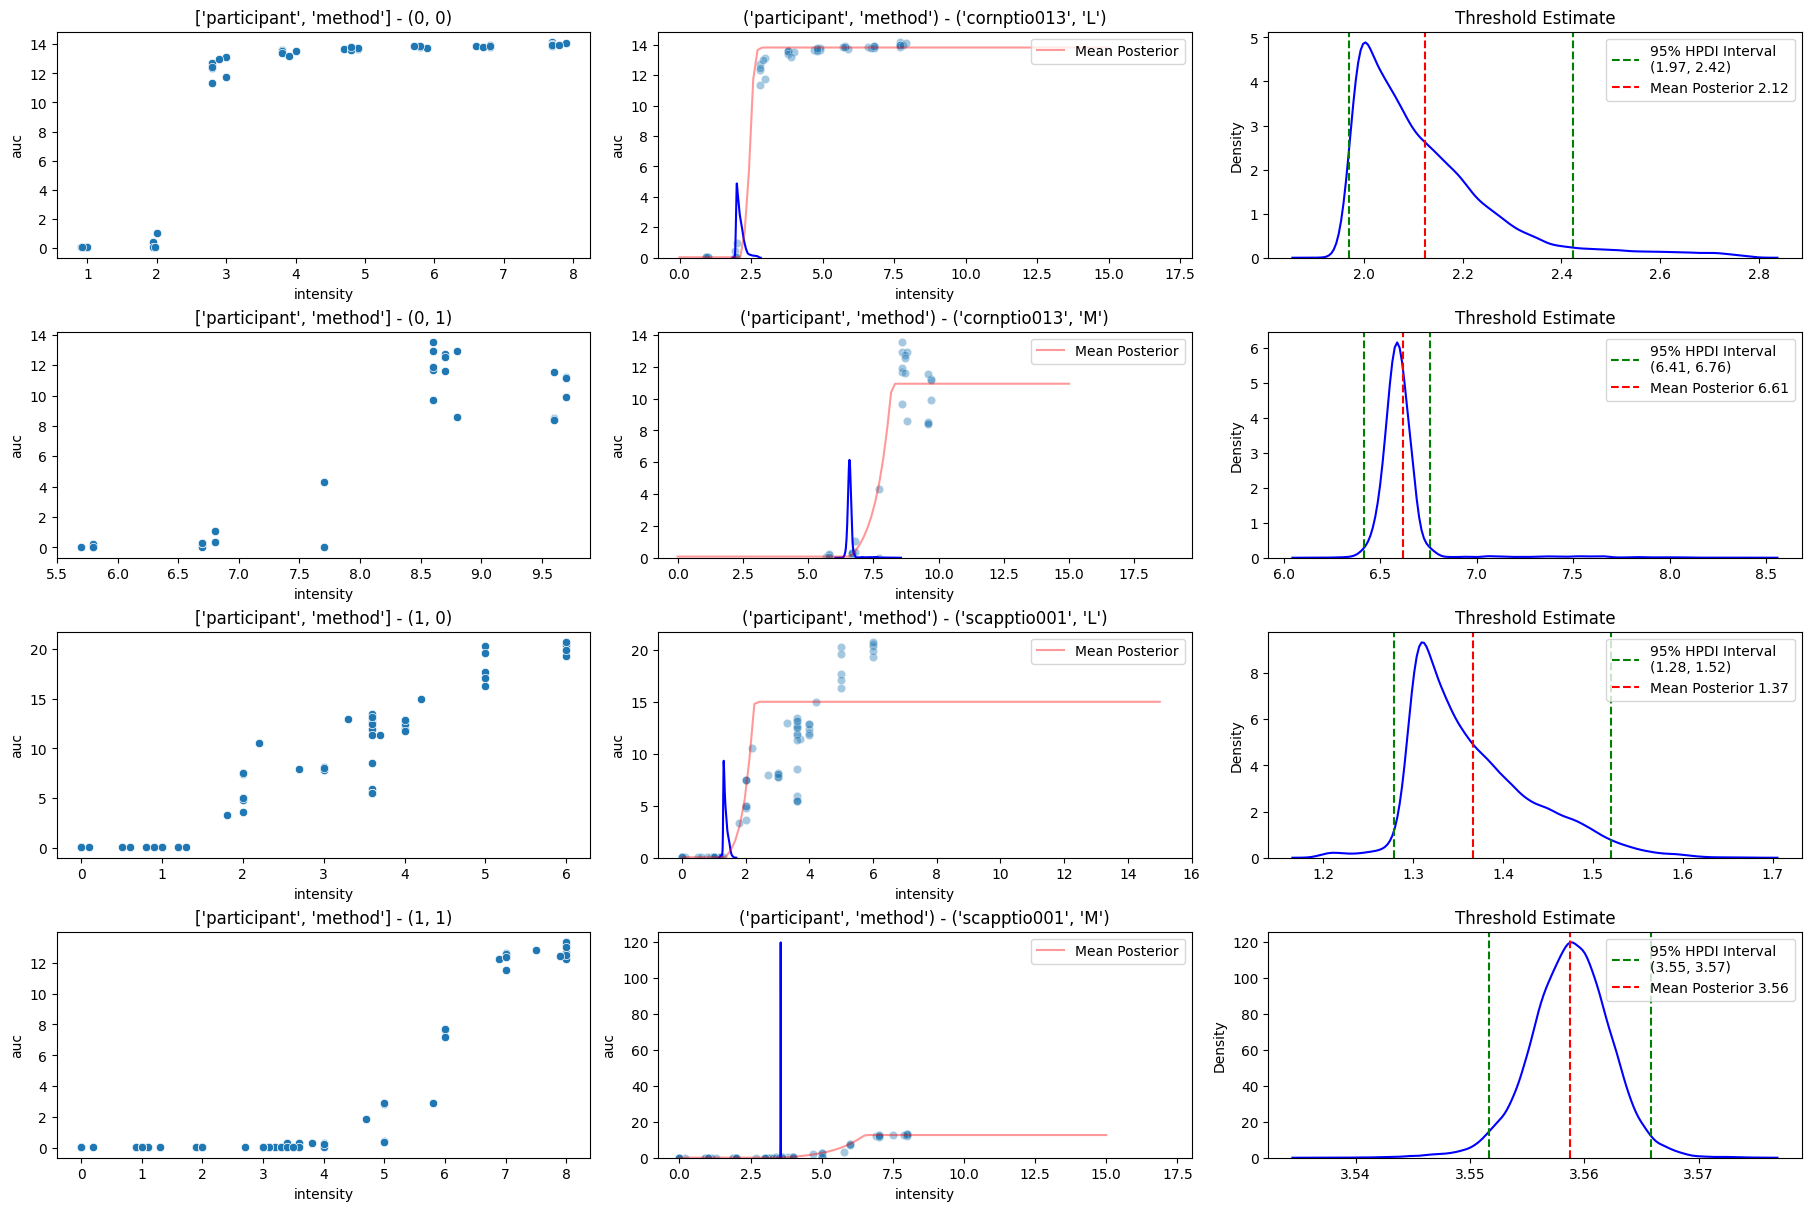

In [10]:
model.plot(df=df, posterior_samples=posterior_samples, encoder_dict=encoder_dict);

#### Information Criterion

In [11]:
numpyro_data = az.from_numpyro(mcmc)

In [12]:
az.loo(numpyro_data)

/home/vishu/repos/hb-mep/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hb-mep/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/vishu/repos/hb-mep/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 24000 posterior samples and 241 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -35.77    41.95
p_loo       66.91        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      233   96.7%
 (0.5, 0.7]   (ok)          3    1.2%
   (0.7, 1]   (bad)         3    1.2%
   (1, Inf)   (very bad)    2    0.8%

In [13]:
az.waic(numpyro_data)

/home/vishu/repos/hb-mep/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 24000 posterior samples and 241 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -32.94    41.88
p_waic       64.09        -

There has been a warning during the calculation. Please check the results.